In [71]:
# TODO
# 1: ColorLine -> DONE
# 2: Make plots of highway/surface/tracktype -> DONE
# 3: Determine paved status rules -> DONE
# 4: Determine city names
# 5: Fix double pathing
# 6: Merge data into single file
# 7: Build separate analysis script
# 8: Make plots: percentage paved vs. unpaved, length of individual paved/unpaved sections

# Other ideas
# Figure out how to plot: closest town, topography type (forest, plains, etc.), elevation profile

## Loading

In [72]:
# Preamble
from IPython.display import IFrame
from itertools import groupby 
from csv import writer
import networkx as nx
import pandas as pd
import numpy as np
import osmnx as ox
import warnings
import folium
import branca.colormap as cm
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import shapely
%matplotlib inline

In [73]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [74]:
# --- Load and process the GPX track
trail = 'gr131'
# trail = 'gr16'
points_per_batch = 100
filename_in = 'data/' + trail + '.csv'
hike = pd.read_csv(filename_in)
coords = hike[['latitude','longitude']].values.tolist()
n_batch = int(np.ceil(hike.shape[0]/points_per_batch))

In [75]:
filename = 'data/' + trail + '_0to' + str(points_per_batch) + '.csv'
df = pd.read_csv(filename,dtype={'surface': str})

In [76]:
# Loading data and merging
for b in range(1,n_batch): # b is the batch counter
    n1 = b*points_per_batch # First point
    n2 = min(n1 + points_per_batch, len(hike)) # Last point
    filename = 'data/' + trail + '_' + str(n1) + 'to' + str(n2) + '.csv'
    df_new = pd.read_csv(filename,dtype={'surface': str})
    df = pd.concat([df,df_new],ignore_index=True)

## Counting highway/surface/tracktype

In [77]:
def grab_first(x):
    if x is not None:
        bb = x.strip('][')
        cc = bb.split(',')
        dd = [element.strip().strip("'") for element in cc]
        return dd[0]
    return x

In [78]:
df['highway'] = df['highway'].replace({np.nan:"none"})
df['surface'] = df['surface'].replace({np.nan:"none"})
df['tracktype'] = df['tracktype'].replace({np.nan:"none"})

In [79]:
df['first_highway'] = df['highway'].apply(grab_first)
df['first_surface'] = df['surface'].apply(grab_first)
df['first_tracktype'] = df['tracktype'].apply(grab_first)

## Defining paved status

In [80]:
def get_paved_status(row):
    tracktype_paved = ['grade1']
    tracktype_unpaved = ['grade2','grade3','grade4','grade5']
    surface_unpaved = ['ground','gravel','grass','unpaved','fine_gravel','wood','dirt','compacted','sand','rock','pebblestone','earth','mud','woodchips','snow','ice','salt']
    highway_unpaved = ['track','path','footway','bridleway']
    
    if row['first_tracktype'] in tracktype_unpaved:
        return False
    elif row['first_tracktype'] in tracktype_paved:
        return True
    else:
        if row['surface'] in surface_unpaved:
            return False
        else:
            if row['highway'] in highway_unpaved:
                return False
            else:
                return True

In [81]:
df['paved'] = df.apply(get_paved_status,axis=1)

## Analyzing statistics

In [82]:
# Paved and unpaved sections
tot_unpaved = df[~df['paved']]['d_cart'].sum()
tot_paved = df[df['paved']]['d_cart'].sum()
tot = tot_unpaved + tot_paved
print(f'Percentage paved: {round(tot_paved/tot,3)}')
print(f'Percentage unpaved: {round(tot_unpaved/tot,3)}')

Percentage paved: 0.681
Percentage unpaved: 0.319


In [83]:
# Figuring out delta_d
df['d_cum'] = df['d_cart'].cumsum()
df['d0'] = df['d_cum'].shift(1)
df.loc[0,'d0'] = 0
df['d1'] = df['d_cum']

## Plotting the route

In [84]:
# Set up ColorLine data
x = df['x0'].values.tolist()
y = df['y0'].values.tolist()
x.extend(df.tail(1)['x1'])
y.extend(df.tail(1)['y1'])
colors = df['paved'].values.tolist()
colors[colors==True] = 1
colors[colors==False] = 0
xy0 = list(zip(x,y))
xy = [[coord[0],coord[1]] for coord in xy0]
colormap = cm.LinearColormap(colors=['#239621','black'],vmin=0.25,vmax=0.75,index=[0.25,0.75])

In [86]:
# Map setup
mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=12, tiles="OpenStreetMap") 
   
# Draw matched route segments
newline = folium.ColorLine(positions=xy, colors=colors, colormap=colormap, weight=3)
newline.add_to(chart)

In [87]:
# Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

## Drawing successive segments

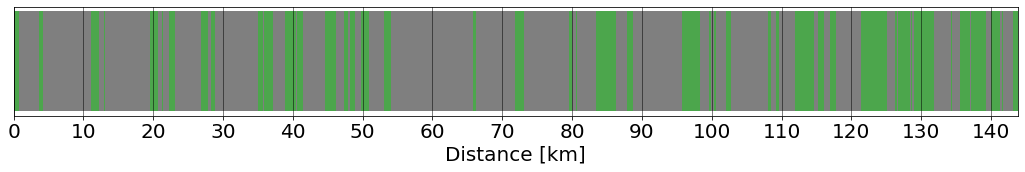

In [98]:
fig, ax = plt.subplots(figsize=(18,2))
plt.rc('font', size=20)
for idx, row in df.iterrows():
    x = [row['d0']/1000,row['d1']/1000]
    y = [1,1]
    if row['paved']:
        plt.plot(x,y,linewidth=100,color='black',solid_capstyle='butt',alpha=0.5)
    else:
        plt.plot(x,y,linewidth=100,color='green',solid_capstyle='butt',alpha=0.7)
plt.xticks(np.arange(0, 1000, step=10))
plt.yticks([])
plt.xlabel('Distance [km]')
plt.xlim(0,df['d1'].loc[df.shape[0]-1]/1000)
ax.set_axisbelow(False)
plt.grid(visible=True,axis='x',alpha=0.5,color='black',linewidth=1)

plt.show()

In [ ]:
# 

## Useful debug things

In [19]:
pd.set_option('display.max_rows', None)
# print(df.groupby(['first_highway','first_surface'])['first_tracktype'].value_counts(dropna=False))
# print(df.groupby(['first_highway','first_tracktype'])['first_surface'].value_counts(dropna=False))
print(df.groupby(['first_tracktype','first_surface'])['first_highway'].value_counts(dropna=False))
pd.reset_option('display.max_rows')

first_tracktype  first_surface    first_highway
grade1           asphalt          track              12
                 concrete         unclassified        9
                 grass            track              18
                                  unclassified       12
                 none             unclassified        2
                 paved            unclassified        6
grade2           fine_gravel      track              27
                 gravel           track               1
grade3           asphalt          unclassified       23
                 ground           path               36
                                  track               5
                 none             track              11
                                  service             2
grade4           compacted        track               2
                 grass_paver      track              58
                 none             track              15
grade5           grass            track               5


In [20]:
# grade3 asphalt unclassified
# mask_grade = df['first_tracktype']=='grade3'
# mask_surface = df['first_surface']=='asphalt'
# mask_highway = df['first_highway']=='unclassified'
# mask_tot = mask_grade & mask_surface & mask_highway

# bridleway
mask_highway = df['first_highway']=='bridleway'
mask_tot = mask_highway

# grade1
mask_grade = df['first_tracktype']=='grade1'
mask_tot = mask_grade

subset = df[mask_tot]

# Trying out ColorLine
# x = subset['x0'].values.tolist()
# y = subset['y0'].values.tolist()
# x.extend(df.tail(1)['x1'])
# y.extend(df.tail(1)['y1'])
# xy0 = list(zip(x,y))
# xy = [[coord[0],coord[1]] for coord in xy0]

# colormap = cm.LinearColormap(colors='black',vmin=0.25,vmax=0.75,index=[0.25,0.75])

mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=12, tiles="OpenStreetMap") # Map setup
    
# newline = folium.ColorLine(positions=xy, colors=colors, colormap=colormap, weight=3)
# newline.add_to(chart)
    
for idx, row in subset.iterrows():
    c = [[row['x0'],row['y0']],
         [row['x1'],row['y1']]]
    newline = folium.PolyLine(locations=c, color='red', weight=5, popup='None')
    newline.add_to(chart)

# # Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)